In [6]:
import random
from matrixgrad.engine import Tensor
from matrixgrad.nn import MLP
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
np.random.seed(1337)
random.seed(1337)

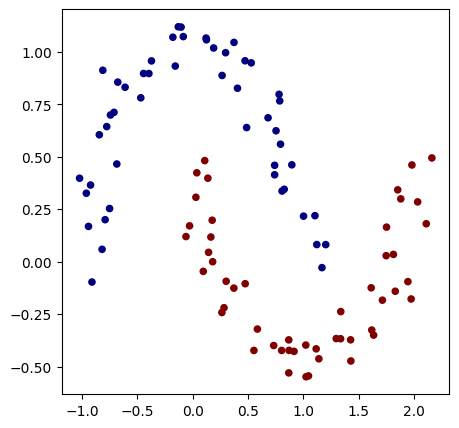

In [8]:
from sklearn.datasets import make_moons, make_blobs

X, y = make_moons(n_samples=100, noise=0.1)

y = y * 2 - 1  # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap="jet")

In [9]:
# initialize a model
model = MLP( [2,64,32],1)  # 2-layer neural network
model(X[0])


Tensor(data=[[3.56859829]], grad=[[0.]])

In [10]:
y=y.reshape(1,-1)

def loss(batch_size=None):
    if batch_size is None:
        Xb, yb = Tensor(X), Tensor(y.T)  # Full dataset
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]  # Select a random batch
        Xb, yb = Tensor(X[ri]), Tensor(y[ri].T)

    # Forward pass through the model
    inputs = Xb  # Convert Xb to a Tensor
    scores = model(inputs)  # Scores will now be a Tensor


    # SVM "max-margin" loss
    one = Tensor(1)  # Maintain this as a tensor for autograd
    margins = one - scores * yb  # Element-wise multiplication

    margins = margins.relu()

    margins = margins / Tensor(len(yb.data[0]))

    # Instead of constructing a new tensor, use the existing margin tensor to accumulate loss
    data_loss = margins.sum()
  

    # L2 regularization (stay in the autograd graph)
    alpha = Tensor(1e-4)
    reg_loss = alpha * sum(
        (p * p).sum() for p in model.parameters()
    )  # Regularization term
    total_loss = data_loss + reg_loss  # Total loss

    # Accuracy computation (vectorized)
    accuracy = ((np.array(yb.data) > 0) == (np.array(scores.data) > 0)).mean()

    return total_loss, accuracy, scores


total_loss, acc, scores = loss()


print("Random accuracy: %.2f%%" % (100 * acc))

Random accuracy: 50.00%


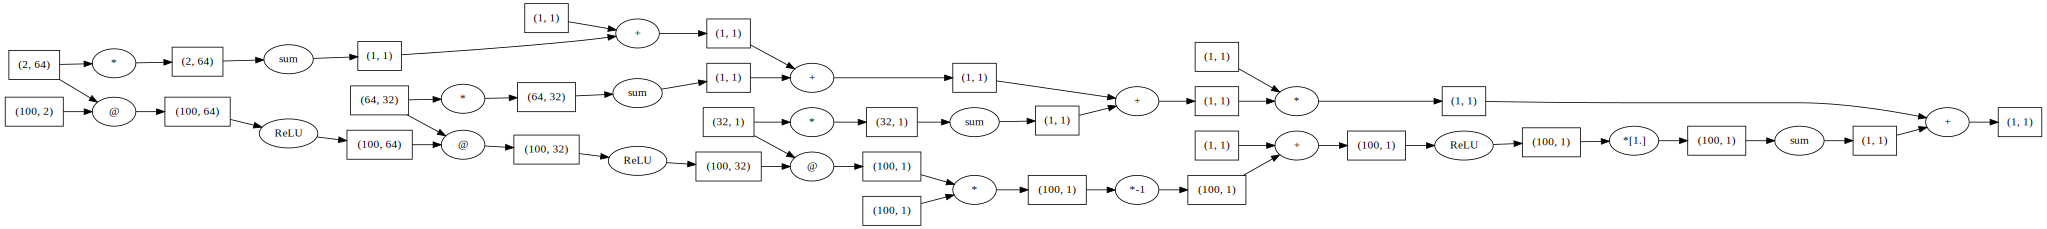

In [14]:
total_loss.visualize()

Step 0, Loss: [[226.11052491]], Accuracy: 50.0%
Step 100, Loss: [[24.64539822]], Accuracy: 86.0%
Step 200, Loss: [[23.1865968]], Accuracy: 86.0%
Early stopping at step 248, no improvement for 10 steps.


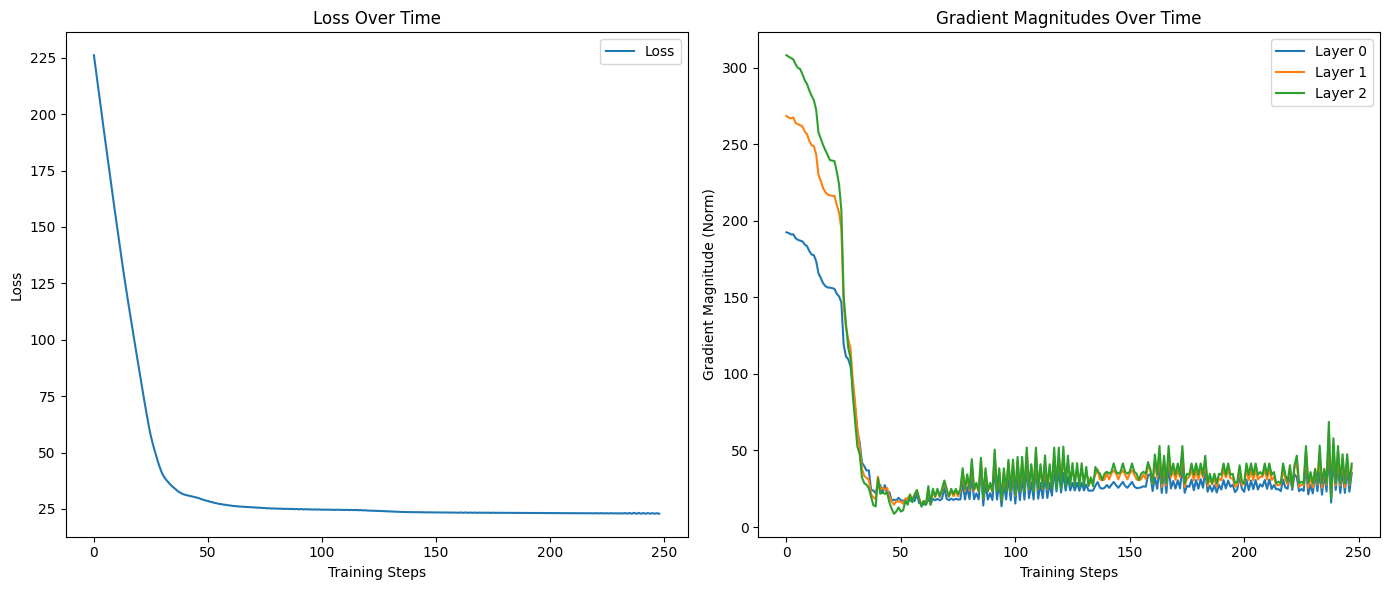

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize a dictionary to store gradient norms
gradient_magnitudes = {name: [] for name, _ in enumerate(model.parameters())}
losses = []

# Early stopping settings
patience = 10  # Number of steps with no improvement before stopping
best_loss = float("inf")  # Start with infinity as the best loss
patience_counter = 0  # Counter to keep track of no improvement
early_stopping = False  # Flag for early stopping

t = 10000  # Total training steps

for k in range(t):

    # Forward pass
    total_loss, acc, scores = loss()

    # Track the loss value
    current_loss = total_loss.data[0][0]
    losses.append(current_loss)

    # Early stopping logic
    if current_loss < best_loss:
        best_loss = current_loss  # Update the best loss
        patience_counter = 0  # Reset the patience counter
    else:
        patience_counter += 1  # Increment if no improvement

    # Stop training if no improvement for `patience` steps
    if patience_counter >= patience:
        print(f"Early stopping at step {k}, no improvement for {patience} steps.")
        early_stopping = True
        break

    # Learning rate schedule
    learning_rate = 0.01 - 0.001 * k / t

    # Zero out gradients before backward pass
    model.zero_grad()

    # Backward pass
    total_loss.backward()

    # Update parameters using SGD and track gradient norms
    for i, p in enumerate(model.parameters()):
        # Calculate gradient norm (magnitude)
        grad_norm = np.linalg.norm(p.grad)
        gradient_magnitudes[i].append(grad_norm)  # Track gradient norm

        # SGD update step with normalization of gradients
        p.data -= (learning_rate * p.grad) / grad_norm

    # Print status every 100 steps
    if k % 100 == 0:
        print(f"Step {k}, Loss: {total_loss.data}, Accuracy: {acc * 100}%")

    # Break if early stopping is triggered
    if early_stopping:
        break

# Plotting both loss and gradient magnitudes

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot loss over time
ax[0].plot(losses, label="Loss")
ax[0].set_title("Loss Over Time")
ax[0].set_xlabel("Training Steps")
ax[0].set_ylabel("Loss")
ax[0].legend()

# Plot gradient magnitudes over time for each layer
for i, norms in gradient_magnitudes.items():
    ax[1].plot(norms, label=f"Layer {i}")
ax[1].set_title("Gradient Magnitudes Over Time")
ax[1].set_xlabel("Training Steps")
ax[1].set_ylabel("Gradient Magnitude (Norm)")
ax[1].legend()

plt.tight_layout()
plt.show()

(-1.548639298268643, 1.951360701731357)

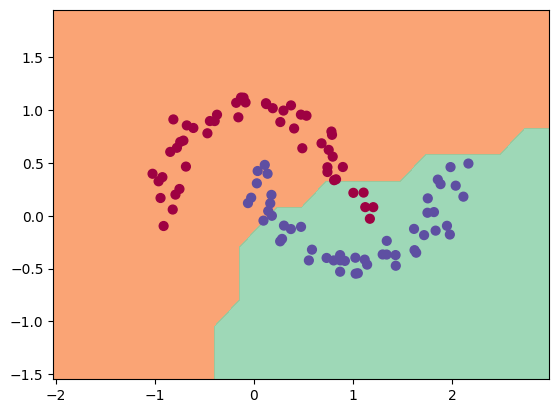

In [12]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = Tensor(Xmesh)
scores = model(inputs)
Z = np.array([s > 0 for s in scores.data])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())